# Primary and subsequent fraction

This notebook creates the extended Primary and subsequent fraction figure from the SI material

In [9]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import seaborn as sns
import pandas as pd
import datetime
import matplotlib.ticker as ticker

sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

countries = ["England","Scotland","Germany","France","Spain","Slovakia","Portugal","Netherlands","Italy","Czechia","Belgium","Austria"]
traces, models, dls = [], [], []
for country in tqdm(countries):
    #'UEFA-beta=False-country=England-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-tune=200-draws=300-max_treedepth=10.pickled'
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.2"+
        f"-uc=True"
        f"-len=normal"+                    
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None:
        print(" not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/12 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 8000 sample runs for Scotland
Use 8000 sample runs for Germany
Use 4000 sample runs for France
Use 8000 sample runs for Spain
Use 8000 sample runs for Slovakia
Use 4000 sample runs for Portugal
Use 8000 sample runs for Netherlands
Use 8000 sample runs for Italy
Use 8000 sample runs for Czechia
Use 8000 sample runs for Belgium
Use 8000 sample runs for Austria


In [10]:
infections_no = []
infections_primary = []
infections_secondary = []
for i, country in tqdm(enumerate(countries)):
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_data/primary_and_subsequent/{country}.pkl")
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    x = pd.date_range(models[i].sim_begin, models[i].sim_end)
    y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4])
    y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y0
    y2 = traces[i].posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - model.sim_begin).days
    i_end = (end - model.sim_begin).days + 1  # inclusiv last day

    y0 = np.sum(y0[..., i_begin:i_end, :], axis=-2)
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=-2)
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=-2)

    infections_no.append(y0)
    infections_primary.append(y1)
    infections_secondary.append(y2)

0it [00:00, ?it/s]

In [11]:

data_primary  = pd.DataFrame()
means = []
for i,country in enumerate(countries):
    # compute fraction of infected people
    t_numpy = infections_primary[i] / (infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary = pd.concat([data_primary, temp])
    means.append(np.mean(temp["percentage_primary"]))

country_order_primar = np.argsort(means)[::-1]

data_primary_and_subsequent = pd.DataFrame()
means = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = (infections_primary[i]+infections_secondary[i])/(infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary_and_subsequent", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary_and_subsequent = pd.concat([data_primary_and_subsequent, temp])
    means.append(np.mean(temp["percentage_primary_and_subsequent"]))
country_order_primary_and_subsequent = np.argsort(means)[::-1]


# As the conctac matrix is symmetric for the subsequant infections we can just plot the violin plots
data_subsequent = pd.DataFrame()
means = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = infections_secondary[i].sum(axis=-1)/(infections_no[i] + infections_primary[i] + infections_secondary[i]).sum(axis=-1) * 100

    # Create dataframe for plotting
    temp = pd.DataFrame(t_numpy, columns=["percentage_secondary"])
    temp["country"] = country
    data_subsequent = pd.concat([data_subsequent, temp])
    means.append(np.median(temp["percentage_secondary"]))

country_order_subsequent = np.argsort(means)[::-1]


/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:820: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:831: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(


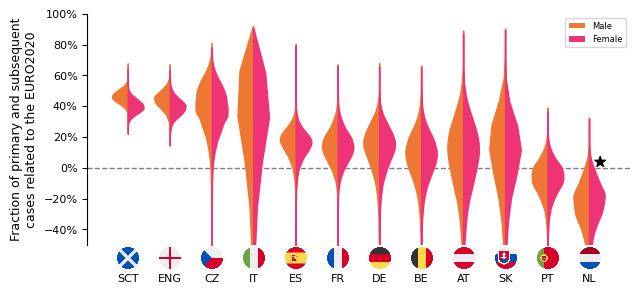

In [17]:
from covid19_soccer.plot.rcParams import *
from covid19_soccer.plot.utils import get_flag
from covid19_soccer.plot.other import legend
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


fig, ax = plt.subplots(1, 1, figsize=(7, 3))

color_male = rcParams.color_male
color_female = rcParams.color_female
"""
sns.violinplot(
    data=data_primary,
    y="percentage_primary",
    x="country",
    hue="gender",
    scale="count",
    inner=None,
    orient="v",
    split=True,
    linewidth=1,
    saturation=1,
    width=0.75,
    palette={"male": color_male, "female": color_female},
    order=np.array(countries)[country_order],
    ax=ax
)
"""

sns.violinplot(
    data=data_primary_and_subsequent,
    y="percentage_primary_and_subsequent",
    x="country",
    hue="gender",
    scale="count",
    inner=None,
    split=True,
    orient="v",
    linewidth=1,
    saturation=1,
    width=0.75,
    bw=0.1,
    order=np.array(countries)[country_order_primary_and_subsequent],
    ax=ax,
    legend = False,
    cut=0,
)

ax.set_ylim(-50,100)

# Remove legend
ax.legend([], [], frameon=False)
colors_base = ["#fe904c","#92b0ff","#e667a5"]
color1 = colors_base[0]
color2 = colors_base[1]

for i, col in enumerate(ax.collections):
    if i % 2 == 0:
        ax.collections[i].set_edgecolor(color_male)  # Set outline colors
        ax.collections[i].set_facecolor(color_male)
    else:
        ax.collections[i].set_edgecolor(color_female)  # Set outline colors
        ax.collections[i].set_facecolor(color_female)


""" Markup
"""
ax.set_ylabel("Fraction of primary and subsequent\ncases related to the EURO2020")
ax.set_xlabel("")
ax.set_xticklabels(country_order_primary_and_subsequent)

# plot flags if desired
plot_flags = True
if plot_flags:
    iso2 = []
    for i, dl in enumerate(np.array(dls)[country_order_primary_and_subsequent]):
        t_iso2 = dl.countries_iso2[0].replace("GB-", "")
        iso2.append(t_iso2)
        img = plt.imread(get_flag(dl.countries_iso2[0].lower(),"../figures/"))
        im = OffsetImage(img, zoom=0.03)
        im.image.axes = ax
        ab = AnnotationBbox(
            im,
            (i, -50),
            xybox=(0.0, -10.0),
            frameon=False,
            xycoords="data",
            boxcoords="offset points",
            pad=0,
        )
        ax.add_artist(ab)
    ax.set_xticklabels(iso2)
    ax.tick_params(axis="x", which="major", pad=21, length=0)

ax.axhline(0, color="tab:gray", ls="--", zorder=-5, lw=1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(100,0))
# Place star at netherlands
ax.scatter(11.2,3,marker='$\star$',color="black",s=100)
ax.spines["bottom"].set_visible(False)
legend(ax,False,False,False,False,True,False,loc="upper right")

plt.show()
fig.savefig(f"../figures/primary_and_subsequent.pdf", **save_kwargs)
fig.savefig(f"../figures/primary_and_subsequent.png", **save_kwargs)
plt.close(fig=fig)